## Packages

In [3]:
## Packages
import pandas as pd
import numpy as np
import datetime as dt
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline


# Zip code data
from uszipcode import SearchEngine
search = SearchEngine()

# Weather data NOAA Token
noaa_token = 'yiRBtFdEyIuOllHGTCbMjRpKIyuDiAgB'

# AQI Data from EPA

In [67]:
## Test API Access

# Link for data
link_in = ("https://aqs.epa.gov/data/api/dailyData/" +
           "byCounty?email=blake.j.hamm@gmail.com&key=khakiwren74" +
           "&param=88101&bdate=20160101&edate=20161231&state=49&county=035")

# Get data
response = requests.get(link_in) # Get data
dictionary = response.json() # Define as JSON
df_test = pd.json_normalize(dictionary['Data'])
#df_test.head()

In [7]:
## Load full data

# Function to loop through 2016 - 2020
def build_airq_df(year):
    # Link for data
    link_sub = ("https://aqs.epa.gov/data/api/dailyData/" +
                "byCounty?email=blake.j.hamm@gmail.com&key=khakiwren74" +
                "&param=88101&bdate=" + year + "0101&edate=" + year + "1231&state=49&county=035")

    # Get data
    response = requests.get(link_sub) # Get data
    dictionary = response.json() # Define as JSON
    df_sub = pd.json_normalize(dictionary['Data'])
    return(df_sub)
    
    
    
# Loop through years to gather data
years = range(2010,2021,1)
df_airq = pd.DataFrame()
for i in years:
    print(i)
    df_airq = df_airq.append(build_airq_df(str(i)))
    

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


### Exploratory Data Analysis (EDA)

In [8]:
## View Data
display(df_airq.head(3))
display(df_airq.tail(3))
print(df_airq.columns)
print(df_airq.aqi.describe())
print(df_airq.shape)
print(df_airq.date_local.describe())

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,49,035,1001,88101,1,40.708611,-112.094722,WGS84,PM2.5 - Local Conditions,24 HOUR,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Magna,"2935 SOUTH 8560 WEST MAGNA,UTAH",Utah,Salt Lake,Magna,41620,"Salt Lake City, UT",2019-05-21
1,49,035,1001,88101,1,40.708611,-112.094722,WGS84,PM2.5 - Local Conditions,24 HOUR,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Magna,"2935 SOUTH 8560 WEST MAGNA,UTAH",Utah,Salt Lake,Magna,41620,"Salt Lake City, UT",2019-05-21
2,49,035,1001,88101,1,40.708611,-112.094722,WGS84,PM2.5 - Local Conditions,24 HOUR,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Magna,"2935 SOUTH 8560 WEST MAGNA,UTAH",Utah,Salt Lake,Magna,41620,"Salt Lake City, UT",2019-05-21


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
19573,49,035,3010,88101,2,40.78422,-111.931,WGS84,PM2.5 - Local Conditions,24 HOUR,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,ROSE PARK,1250 NORTH 1400 WEST,Utah,Salt Lake,Salt Lake City,41620,"Salt Lake City, UT",2021-01-28
19574,49,035,3010,88101,2,40.78422,-111.931,WGS84,PM2.5 - Local Conditions,24 HOUR,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,ROSE PARK,1250 NORTH 1400 WEST,Utah,Salt Lake,Salt Lake City,41620,"Salt Lake City, UT",2021-01-28
19575,49,035,3010,88101,2,40.78422,-111.931,WGS84,PM2.5 - Local Conditions,24 HOUR,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,ROSE PARK,1250 NORTH 1400 WEST,Utah,Salt Lake,Salt Lake City,41620,"Salt Lake City, UT",2021-01-28


Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration',
       'pollutant_standard', 'date_local', 'units_of_measure', 'event_type',
       'observation_count', 'observation_percent', 'validity_indicator',
       'arithmetic_mean', 'first_max_value', 'first_max_hour', 'aqi',
       'method_code', 'method', 'local_site_name', 'site_address', 'state',
       'county', 'city', 'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')
count    86359.000000
mean        30.070091
std         22.496347
min          0.000000
25%         15.000000
50%         23.000000
75%         37.000000
max        194.000000
Name: aqi, dtype: float64
(97319, 31)
count          97319
unique          4010
top       2020-08-21
freq              74
Name: date_local, dtype: object


In [9]:
## Get zip code
#zip_temp = search.by_city(city="Murray") # Throws error
#display(zip_temp)

# Get empty dictionary
d_zip = {}

for city in df_airq['city'].unique():
    print(city)
    try:
        d_zip[city] = search.by_city_and_state(city=city, state = 'UT')[0].zipcode
    except:
        d_zip[city] = search.by_city_and_state(city="Salt Lake City", state = 'UT')[0].zipcode
        
# Add zip to dataframe
df_airq['zip'] = df_airq['city'].map(d_zip)

Magna
Salt Lake City
Herriman
Midvale
Murray


In [10]:
## Clean Date field
df_airq['date_local'] = pd.to_datetime(df_airq['date_local'])

aqi    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

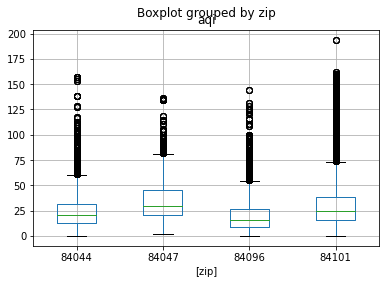

In [11]:
# Boxplot of aqi by city
df_airq[['zip','aqi']].boxplot(by = 'zip', return_type = 'axes')

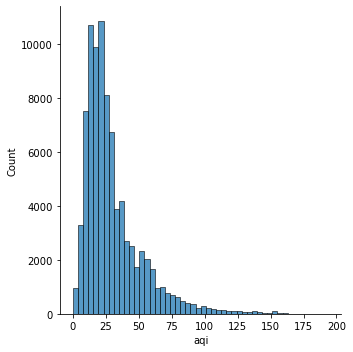

In [12]:
# Historgram
sns.displot(df_airq['aqi'], bins = 50)
plt.show()

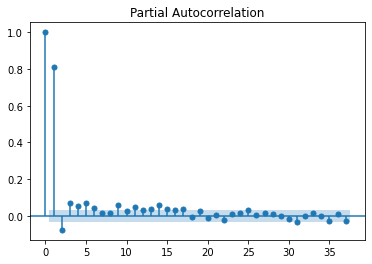

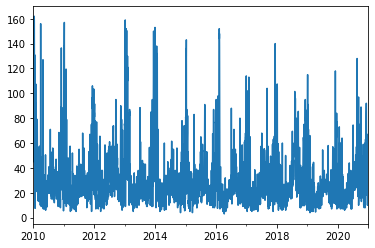

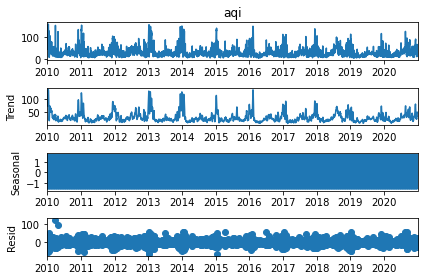

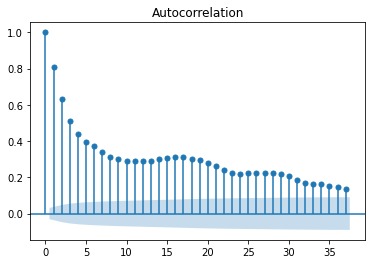

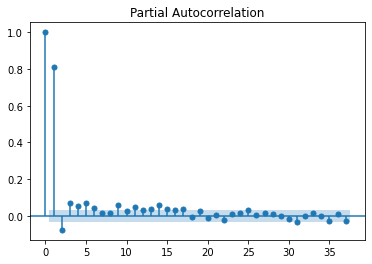

In [60]:
# Explore aqi over time
ts_airq = df_airq.groupby('date_local')['aqi'].median()

# Check for NA values
idx = pd.date_range(min(ts_airq.index),max(ts_airq.index))
ts_airq = ts_airq.reindex(idx, fill_value = np.NaN)
ts_airq.interpolate(method = 'linear',inplace = True)
ts_airq.sort_index(inplace= True)

# Plot
ts_airq.plot()
ts_airq.asfreq('d')

# Decompose
ts_decomposed = seasonal_decompose(ts_airq, 'additive')
ts_decomposed.plot()

# Test ACF and PACF
plot_acf(ts_airq)
plot_pacf(ts_airq)

# Manufacturing GDP Utah

In [61]:
# Get Fred API data
from fredapi import Fred
fred = Fred(api_key='c67797b8c9b9824fbf5686344e4d1b3e') # API Key
ts_manu = fred.get_series('EXPMANUT') # Already formatted as ts!!

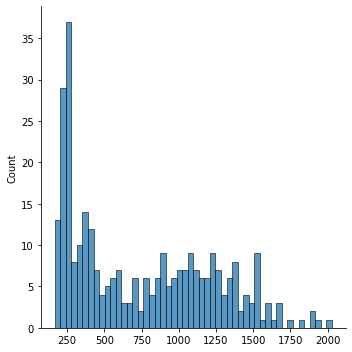

In [62]:
# Historgram
sns.displot(ts_manu, bins = 50)
plt.show()

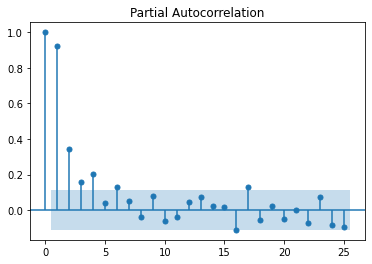

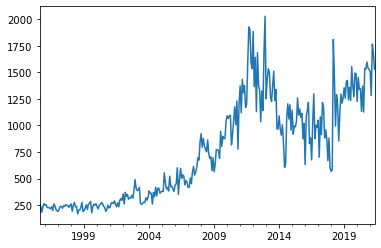

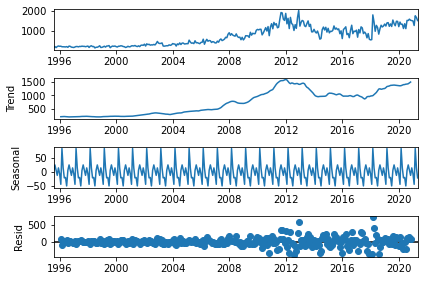

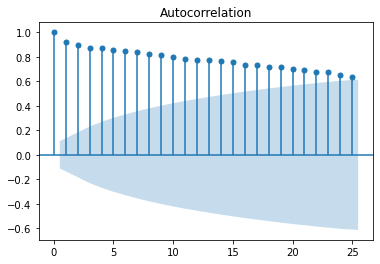

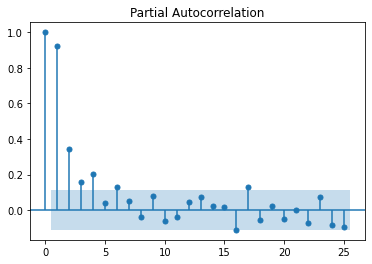

In [63]:
# Explor data
# Plot
ts_manu.plot()
ts_manu.asfreq('d')

# Decompose
ts_decomposed = seasonal_decompose(ts_manu, 'additive')
ts_decomposed.plot()

# Test ACF and PACF
plot_acf(ts_manu)
plot_pacf(ts_manu)

# Weather Data

In [66]:
# Get info
info_url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/datatypes?stationid=GHCND:USW00024127&limit=1000'
info_resp = requests.get(info_url, headers={'token':noaa_token})
#info_resp.json()

In [74]:
## Pull full weather data

# Function to call api
def build_weather_df(datatypeid, year, station_id = 'GHCND:USW00024127'):
    response = requests.get(
        ('https://www.ncdc.noaa.gov/cdo-web/api/v2/' +
         'data?datasetid=GHCND' + 
         '&datatypeid='+ datatypeid + 
         '&limit=1000' +
         '&stationid=' + station_id +
         '&startdate=' + year + '-01-01&enddate=' + year + '-12-31'), 
        headers={'token':noaa_token})
    
    dictionary = response.json() # Define as JSON
    #print(dictionary)
    df_sub = pd.json_normalize(dictionary['results'])
    
    return(df_sub)

#test = call_api('TAVG','2016')

# Prepare inputs/outputs
datatypeid_ls = ['TAVG','PRCP','AWND']
df_weather = pd.DataFrame()

# Get 2013 - 2020 data (only data available)
for year in range(2013,2021):
    for datatypeid in datatypeid_ls:
        year = str(year)
        print(datatypeid, year)
        
        # Get Data API
        df_weather = df_weather.append(build_weather_df(datatypeid,year))

TAVG 2013
PRCP 2013
AWND 2013
TAVG 2014
PRCP 2014
AWND 2014
TAVG 2015
PRCP 2015
AWND 2015
TAVG 2016
PRCP 2016
AWND 2016
TAVG 2017
PRCP 2017
AWND 2017
TAVG 2018
PRCP 2018
AWND 2018
TAVG 2019
PRCP 2019
AWND 2019
TAVG 2020
PRCP 2020
AWND 2020


# Fire Data

In [79]:
dictionary['Data']

[{'state_code': '49',
  'county_code': '035',
  'site_number': '3013',
  'parameter_code': '88101',
  'poc': 3,
  'latitude': 40.496392,
  'longitude': -112.036298,
  'datum': 'WGS84',
  'parameter': 'PM2.5 - Local Conditions',
  'sample_duration': '24-HR BLK AVG',
  'pollutant_standard': 'PM25 Annual 2012',
  'date_local': '2016-12-31',
  'units_of_measure': 'Micrograms/cubic meter (LC)',
  'event_type': 'None',
  'observation_count': 1,
  'observation_percent': 100.0,
  'validity_indicator': 'Y',
  'arithmetic_mean': 24.3,
  'first_max_value': 24.3,
  'first_max_hour': 0,
  'aqi': 77,
  'method_code': '182',
  'method': 'Thermo Scientific TEOM 1405-DF Dichotomous FDMS - FDMS Gravimetric',
  'local_site_name': None,
  'site_address': '14058 Mirabella Dr.',
  'state': 'Utah',
  'county': 'Salt Lake',
  'city': 'Herriman',
  'cbsa_code': '41620',
  'cbsa': 'Salt Lake City, UT',
  'date_of_last_change': '2019-01-03'},
 {'state_code': '49',
  'county_code': '035',
  'site_number': '3013',

In [82]:
## SOURCES:
# https://www.nwcg.gov/publications/pms437/weather/data-resources
# https://famit.nwcg.gov/applications/FAMWeb
# https://fam.nwcg.gov/fam-web/weatherfirecd/state_data.htm
# https://data.thespectrum.com/fires/

# EPA API SMOKE PARAM: 11204

## Load full data

# Function to loop through 2016 - 2020
def build_smoke_df(year):
    # Link for data
    link_sub = ("https://aqs.epa.gov/data/api/dailyData/" +
                "byState?email=blake.j.hamm@gmail.com&key=khakiwren74" +
                "&param=11204&bdate=" + year + "0101&edate=" + year + "1231&state=49")

    # Get data
    response = requests.get(link_sub) # Get data
    dictionary = response.json() # Define as JSON
    display(dictionary)
    df_sub = pd.json_normalize(dictionary['Data'])
    return(df_sub)
    
    
    
# Loop through years to gather data
years = range(2010,2021,1)
df_smoke = pd.DataFrame()
for i in years:
    print(i)
    df_smoke = df_smoke.append(build_smoke_df(str(i)))
    

2010


{'Header': [{'status': 'No data matched your selection',
   'request_time': '2021-07-12T10:07:42-04:00',
   'url': 'https://aqs.epa.gov/data/api/dailyData/byState?email=blake.j.hamm@gmail.com&key=khakiwren74&param=11204&bdate=20100101&edate=20101231&state=49',
   'rows': 0}],
 'Data': []}

2011


{'Header': [{'status': 'No data matched your selection',
   'request_time': '2021-07-12T10:07:43-04:00',
   'url': 'https://aqs.epa.gov/data/api/dailyData/byState?email=blake.j.hamm@gmail.com&key=khakiwren74&param=11204&bdate=20110101&edate=20111231&state=49',
   'rows': 0}],
 'Data': []}

2012


{'Header': [{'status': 'No data matched your selection',
   'request_time': '2021-07-12T10:07:43-04:00',
   'url': 'https://aqs.epa.gov/data/api/dailyData/byState?email=blake.j.hamm@gmail.com&key=khakiwren74&param=11204&bdate=20120101&edate=20121231&state=49',
   'rows': 0}],
 'Data': []}

2013


{'Header': [{'status': 'No data matched your selection',
   'request_time': '2021-07-12T10:07:44-04:00',
   'url': 'https://aqs.epa.gov/data/api/dailyData/byState?email=blake.j.hamm@gmail.com&key=khakiwren74&param=11204&bdate=20130101&edate=20131231&state=49',
   'rows': 0}],
 'Data': []}

2014


{'Header': [{'status': 'No data matched your selection',
   'request_time': '2021-07-12T10:07:44-04:00',
   'url': 'https://aqs.epa.gov/data/api/dailyData/byState?email=blake.j.hamm@gmail.com&key=khakiwren74&param=11204&bdate=20140101&edate=20141231&state=49',
   'rows': 0}],
 'Data': []}

2015


{'Header': [{'status': 'No data matched your selection',
   'request_time': '2021-07-12T10:07:45-04:00',
   'url': 'https://aqs.epa.gov/data/api/dailyData/byState?email=blake.j.hamm@gmail.com&key=khakiwren74&param=11204&bdate=20150101&edate=20151231&state=49',
   'rows': 0}],
 'Data': []}

2016


{'Header': [{'status': 'No data matched your selection',
   'request_time': '2021-07-12T10:07:45-04:00',
   'url': 'https://aqs.epa.gov/data/api/dailyData/byState?email=blake.j.hamm@gmail.com&key=khakiwren74&param=11204&bdate=20160101&edate=20161231&state=49',
   'rows': 0}],
 'Data': []}

2017


{'Header': [{'status': 'No data matched your selection',
   'request_time': '2021-07-12T10:07:46-04:00',
   'url': 'https://aqs.epa.gov/data/api/dailyData/byState?email=blake.j.hamm@gmail.com&key=khakiwren74&param=11204&bdate=20170101&edate=20171231&state=49',
   'rows': 0}],
 'Data': []}

2018


{'Header': [{'status': 'No data matched your selection',
   'request_time': '2021-07-12T10:07:46-04:00',
   'url': 'https://aqs.epa.gov/data/api/dailyData/byState?email=blake.j.hamm@gmail.com&key=khakiwren74&param=11204&bdate=20180101&edate=20181231&state=49',
   'rows': 0}],
 'Data': []}

2019


{'Header': [{'status': 'No data matched your selection',
   'request_time': '2021-07-12T10:07:47-04:00',
   'url': 'https://aqs.epa.gov/data/api/dailyData/byState?email=blake.j.hamm@gmail.com&key=khakiwren74&param=11204&bdate=20190101&edate=20191231&state=49',
   'rows': 0}],
 'Data': []}

2020


{'Header': [{'status': 'No data matched your selection',
   'request_time': '2021-07-12T10:07:47-04:00',
   'url': 'https://aqs.epa.gov/data/api/dailyData/byState?email=blake.j.hamm@gmail.com&key=khakiwren74&param=11204&bdate=20200101&edate=20201231&state=49',
   'rows': 0}],
 'Data': []}